In [1]:
import datetime

import matplotlib.pyplot as plt
import numpy as np

import metagames.functional as mf

In [2]:
default_agent_config = {
    'num_parameters': 10,
    'initializer': 'scaled_normal',
    'loss': 'utility',
    'optimizer': 'adam',
    'learning_rate': 1e-2,
    'step_rate': 1,
    'num_players': 1,
}
agent_configs = [
    {
        'agent': 'sum',
    },
    {
        'agent': 'selfish',
    },
    {
        'agent': 'linear',
    },
    {
        'agent': 'nn',
    },
    {
        'name': 'LinearDefect',
        'agent': 'linear',
        'loss': 'defect',
    }
]

In [3]:
data = mf.main.run_experiment(
    experiment='self_play_self_unaware',
    game='prisoners_dilemma',
    num_steps=1000,
    agents_config=agent_configs,
    default_agent_config=default_agent_config,
    agent_seed=1,
    parameter_seed=2,
)

In [4]:
step_idx = 0         # Global step
player_idx = 0       # Player index (in list of all players data['players']) 
player_step_idx = 0  # Player substep (may take multiple steps per global step)
round_idx = 0        # Substep gradient may be accumulated over multiple rounds with different opponents
data['steps'][step_idx]['player_updates'][player_idx][player_step_idx]['rounds'][round_idx]

{'opponent': PlayerSpecification(agent=SumAgent(), initializer=<function scaled_normal_initializer at 0x7f669dd82730>, loss=<class 'metagames.functional.losses.UtilityLoss'>, optimizer=<class 'torch.optim.adam.Adam'>, learning_rate=0.01, step_rate=1, name='SumAgent'),
 'utility': array(-1.72928428),
 'action_probability': array(0.27071572),
 'opponent_action_probability': array(0.27071572),
 'action_logit': array(-0.99099433),
 'opponent_action_logit': array(-0.99099433)}

In [5]:
start_time = datetime.datetime.fromtimestamp(data['timestamp_start'])
end_time = datetime.datetime.fromtimestamp(data['timestamp_end'])
print('Elapsed Time:', end_time - start_time)

Elapsed Time: 0:00:04.961926


In [6]:
def plot_experiment_utilities(title, data):
    step_statistics = mf.data.experiment_step_statistics(data)

    ax = plt.gca()
    for player, player_stats in step_statistics.items():
        plt.plot(player_stats['utility']['mean'], label=player)

    ax.legend()
    ax.set_ylabel('Utility')
    ax.set_xlabel('Global Step')
    ax.set_title(title)

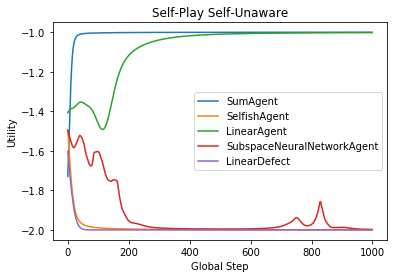

In [7]:
plot_experiment_utilities('Self-Play Self-Unaware', data)
plt.show()

In [8]:
duel_data = mf.main.run_experiment(
    experiment='duel',
    game='prisoners_dilemma',
    num_steps=1000,
    agents_config=[{'agent': 'linear', 'num_players': 2}],
    default_agent_config=default_agent_config,
    agent_seed=1,
    parameter_seed=2,
    log_every_n=500
)

Step 499, Player 0, grad_norm 0.553424
Step 499, Player 0, utility -1.934275
Step 499, Player 1, grad_norm 0.582808
Step 499, Player 1, utility -1.070766
Step 999, Player 0, grad_norm 0.030616
Step 999, Player 0, utility -0.009150
Step 999, Player 1, grad_norm 0.026799
Step 999, Player 1, utility -2.988513


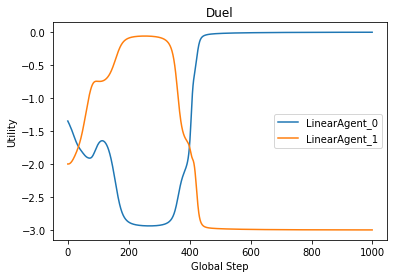

In [9]:
plot_experiment_utilities('Duel', duel_data)
plt.show()

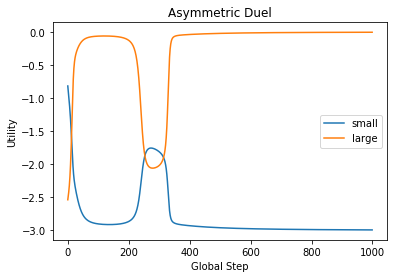

In [10]:
asymmetric_duel_data = mf.main.run_experiment(
    experiment='duel',
    game='prisoners_dilemma',
    num_steps=1000,
    agents_config=[
        {'agent': 'linear', 'num_parameters': 1, 'num_opponent_parameters': 20, 'name': 'small'},
        {'agent': 'linear', 'num_parameters': 20, 'num_opponent_parameters': 1, 'name': 'large'},
    ],
    default_agent_config=default_agent_config,
    agent_seed=1,
    parameter_seed=2,
)
plot_experiment_utilities('Asymmetric Duel', asymmetric_duel_data)
plt.show()

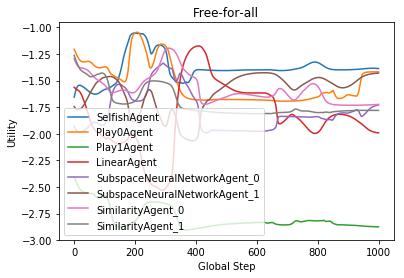

In [11]:
free_for_all_data = mf.main.run_experiment(
    experiment='free_for_all',
    game='prisoners_dilemma',
    num_steps=1000,
    agents_config=[
        {'agent': 'selfish'},
        {'agent': 'defect'},
        {'agent': 'cooperate'},
        {'agent': 'linear'},
        {'agent': 'nn', 'num_players': 2},
        {'agent': 'clique', 'num_players': 2}
    ],
    default_agent_config=default_agent_config,
    agent_seed=1,
    parameter_seed=2,
)
plot_experiment_utilities('Free-for-all', free_for_all_data)
plt.show()